# 041 GDAL: time series : Answers to exercises

#### Exercise 1

We have seen in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb) that you can use `gdal` to creat a GeoTiff format image, for example with:

    g = gdal.Warp(output_name, input_name ,format='GTiff',options=['COMPRESS=LZW'])
    g.FlushCache()

* Convert the `gdal` file `work/stitch_set.vrt` to a more portable GeoTiff file called `work/stitch_set.tif`
* Confirm that this has worked by reading and displaying data from the file

In [4]:
# ANSWER
import gdal

# Convert the `gdal` file `work/stitch_set.vrt` to a 
# more portable GeoTiff file called `work/stitch_set.tif`

# set up the filenames
infile = 'work/stitch_set.vrt'
outfile = 'work/stitch_set.tif'

# convert using gdal.Warp or similar
g = gdal.Warp(outfile, infile ,format='GTiff',options=['COMPRESS=LZW'])
# force write to disk
g.FlushCache()

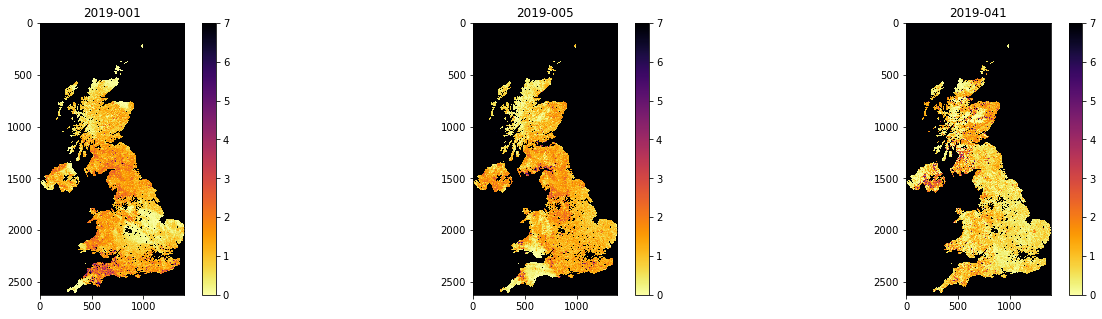

In [5]:
import gdal
import matplotlib.pyplot as plt

# ANSWER
fig, axs = plt.subplots(1,3,figsize=(22,5))
axs = axs.flatten()

for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

#### Exercise 2

* Produce a set of spatial plots of the quantity `Fpar_500m` over Luxembourg for 2019

In [17]:
# ANSWER
msg = '''
Produce a set of spatial 
plots of the quantity `Fpar_500m` over Luxembourg for 2019

This is almost identical to the above, but with a different SDS
'''
from geog0111.modisUtils import getModis
import gdal


warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

kwargs = {
    'tile'      :    ['h18v03','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Fpar_500m',
    'doys'      : [i for i in range(1,366,4)],
    'year'      : 2019,
    'warp_args' : warp_args
}

datafiles,bnames = getModis(verbose=False,timeout=None,**kwargs)
# build VRT
stitch_vrt = gdal.BuildVRT("work/stitch_time.vrt", datafiles,separate=True)
del stitch_vrt

# read data

g = gdal.Warp("","work/stitch_time.vrt",**warp_args)
data = g.ReadAsArray() * 0.1

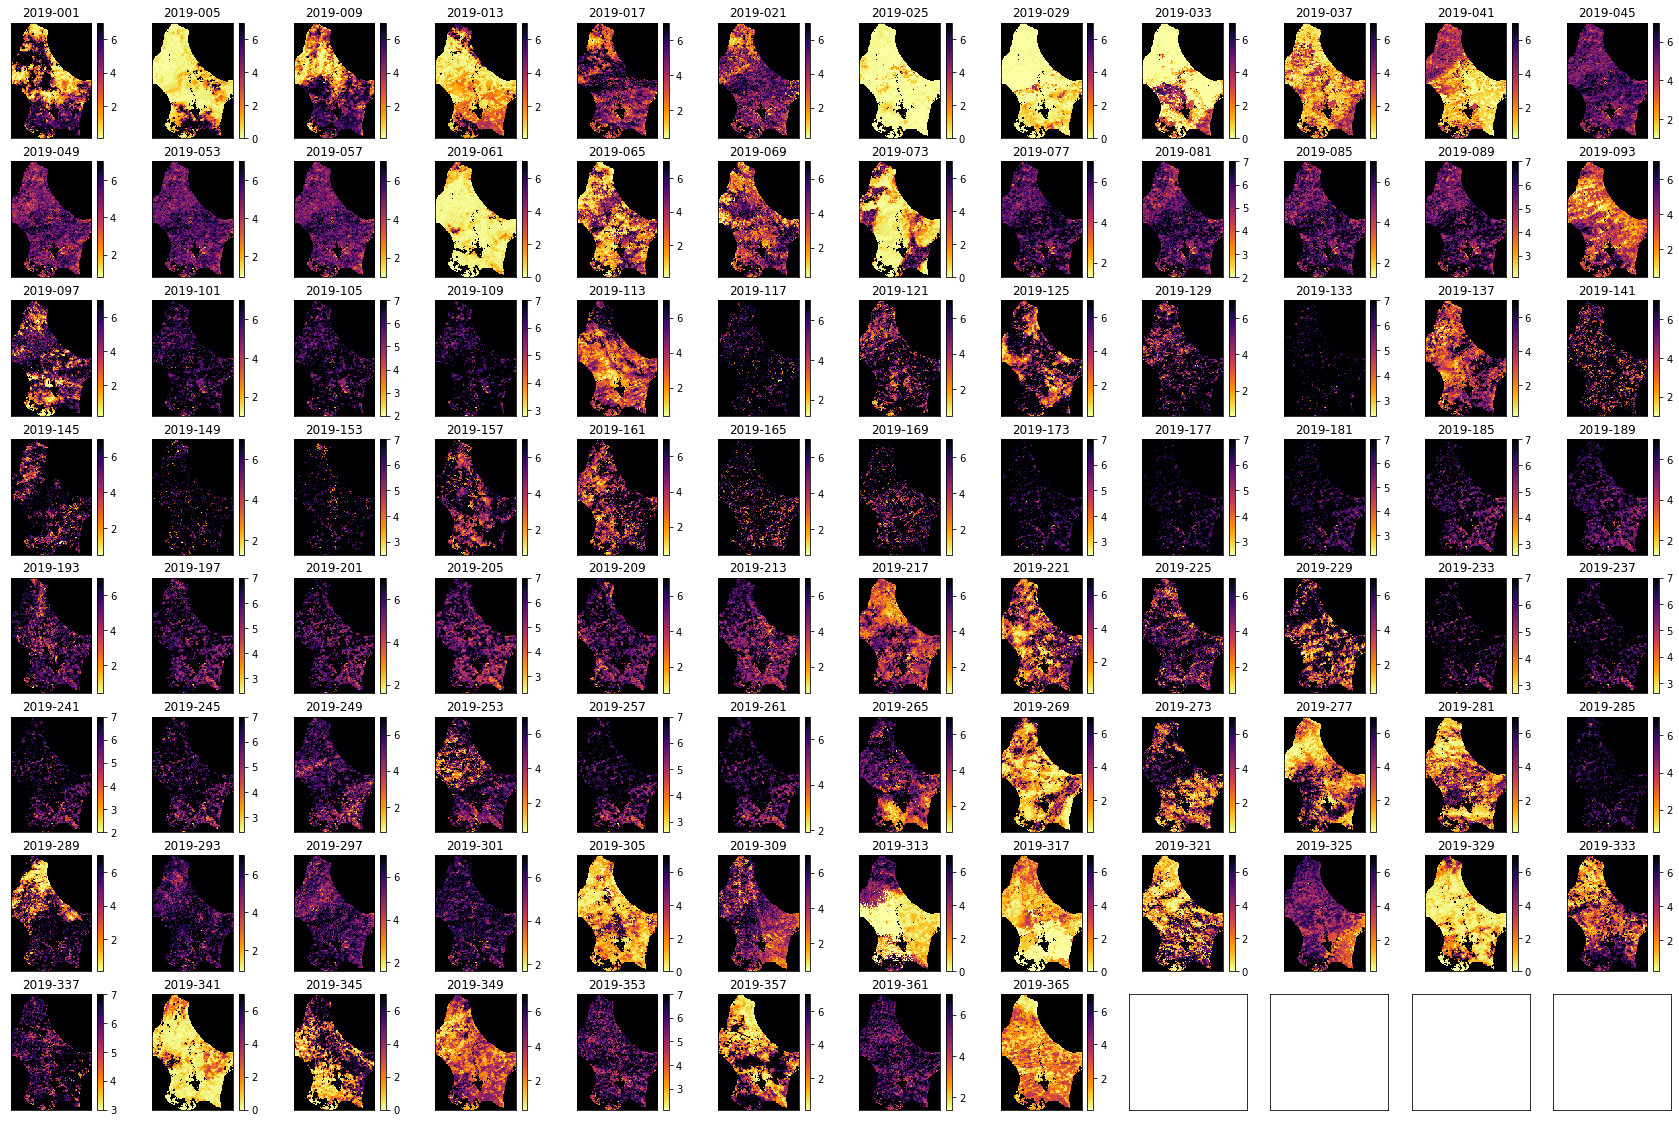

In [18]:
import matplotlib.pyplot as plt

shape=(8,12)
x_size,y_size=(30,20)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])

for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,cmap=plt.cm.inferno_r,\
                       interpolation='nearest')
    axs[i].set_title(bnames[i])
    fig.colorbar(im, ax=axs[i])

#### Exercise 3

Write a function called `modisAnnual(**kwargs)` with arguments based on:

    warp_args = {
        'dstNodata'     : 255,
        'format'        : 'MEM',
        'cropToCutline' : True,
        'cutlineWhere'  : "FIPS='LU'",
        'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }

    kwargs = {
        'tile'      :    ['h18v03','h18v04'],
        'product'   :    'MCD15A3H',
        'sds'       :    ['Lai_500m', 'Fpar_500m'],
        'doys'      : [i for i in range(1,366,4)],
        'year'      : 2019,
        'warp_args' : warp_args
        'ofile_root': 'work/output_filename_ex3'
    }

 
where `sds` is a list of SDS

That returns:

    bnames  : names for the items in first (time) dimension
    odict   : a dictionary with items in sds for keys and the names of associated VRT files as values
    

In [19]:
from geog0111.modisUtils import getModis
from pathlib import Path
import gdal

#ANSWER

msg = '''This is almost the same as the previous exercise, but wrapped as a function with a loop around SDS'''

def modisAnnual(ofile_root='work/output_filename',**kwargs):
    '''
        generate dictionary of SDS datasets as VRT files
    
       arguments based on:

        warp_args = {
            'dstNodata'     : 255,
            'format'        : 'MEM',
            'cropToCutline' : True,
            'cutlineWhere'  : "FIPS='LU'",
            'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
        }

        kwargs = {
            'tile'      :    ['h18v03','h18v04'],
            'product'   :    'MCD15A3H',
            'sds'       :    ['Lai_500m', 'Fpar_500m'],
            'doys'      : [i for i in range(1,366,4)],
            'year'      : 2019,
            'warp_args' : warp_args
        }
        
        Return 
    '''
    sds_list =  kwargs['sds']
    # output dict
    odict = {}
    
    for s in sds_list:
        ofile = f"{ofile_root}_{s}.vrt"
        kwargs['sds'] = s 
        datafiles,bnames = getModis(**kwargs) 
        stitch_vrt = gdal.BuildVRT(ofile, datafiles,separate=True)
        # save the band names
        bofile = Path(f'{ofile}_bands')
        bofile.write_text(' '.join(bnames))
        del stitch_vrt
        odict[s] = ofile
    return odict,bnames
print(msg)

This is almost the same as the previous exercise, but wrapped as a function with a loop around SDS


In [20]:
#ANSWER
#slightly better as does checking to see if file exists 
# and we store the bnames data
def modisAnnual(ofile_root='work/output_filename',**kwargs):
    '''
        generate dictionary of SDS datasets as VRT files
    
       arguments based on:

        warp_args = {
            'dstNodata'     : 255,
            'format'        : 'MEM',
            'cropToCutline' : True,
            'cutlineWhere'  : "FIPS='LU'",
            'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
        }

        kwargs = {
            'tile'      :    ['h18v03','h18v04'],
            'product'   :    'MCD15A3H',
            'sds'       :    ['Lai_500m', 'Fpar_500m'],
            'doys'      : [i for i in range(1,60,4)],
            'year'      : 2019,
            'warp_args' : warp_args
        }
        
        Return odict,bnames
        
        where odict keys are SDS values and the values VRT filenames
    '''
    sds_list =  kwargs['sds']

    # output dict
    odict = {}
    if ('force' in kwargs.keys()) and kwargs['force'] == True:
        redo = True
        del kwargs['force']
    else:
        redo = False
        
    bnames = []  
    for s in sds_list:
        ofile = f"{ofile_root}_SDS_{s}.vrt"
        bofile = Path(f'{ofile}_bands')
        if not redo:
            if (not Path(ofile).exists()) or (not bofile.exists()):
                kwargs['sds'] = s 
                datafiles,bnames = getModis(**kwargs) 
                stitch_vrt = gdal.BuildVRT(ofile, datafiles,separate=True)
                # save the band names
                bofile = Path(f'{ofile}_bands')
                bofile.write_text(' '.join(bnames))
                del stitch_vrt
        else:
            kwargs['sds'] = s 
            datafiles,bnames = getModis(**kwargs) 
            stitch_vrt = gdal.BuildVRT(ofile, datafiles,separate=True)
            del stitch_vrt
            # save the band names
            bofile = Path(f'{ofile}_bands')
            bofile.write_text(' '.join(bnames))
        odict[s] = ofile
        bofile = Path(f'{ofile}_bands')
        bnames = bofile.read_text().split()
    return odict,bnames

In [21]:
#ANSWER

# test


warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

kwargs = {
    'tile'      :    ['h18v03','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    ['Lai_500m', 'Fpar_500m'],
    'doys'      : [i for i in range(1,366,4)],
    'year'      : 2019,
    'verbose'   : False,
    'timeout'   : None,
    'ofile_root': 'work/output_filename_ex3', 
    'warp_args' : warp_args
}

# run
odict,bnames = modisAnnual(**kwargs)

# outputs
print(odict,bnames)

{'Lai_500m': 'work/output_filename_ex3_SDS_Lai_500m.vrt', 'Fpar_500m': 'work/output_filename_ex3_SDS_Fpar_500m.vrt'} ['2019-001', '2019-005', '2019-009', '2019-013', '2019-017', '2019-021', '2019-025', '2019-029', '2019-033', '2019-037', '2019-041', '2019-045', '2019-049', '2019-053', '2019-057', '2019-061', '2019-065', '2019-069', '2019-073', '2019-077', '2019-081', '2019-085', '2019-089', '2019-093', '2019-097', '2019-101', '2019-105', '2019-109', '2019-113', '2019-117', '2019-121', '2019-125', '2019-129', '2019-133', '2019-137', '2019-141', '2019-145', '2019-149', '2019-153', '2019-157', '2019-161', '2019-165', '2019-169', '2019-173', '2019-177', '2019-181', '2019-185', '2019-189', '2019-193', '2019-197', '2019-201', '2019-205', '2019-209', '2019-213', '2019-217', '2019-221', '2019-225', '2019-229', '2019-233', '2019-237', '2019-241', '2019-245', '2019-249', '2019-253', '2019-257', '2019-261', '2019-265', '2019-269', '2019-273', '2019-277', '2019-281', '2019-285', '2019-289', '2019-

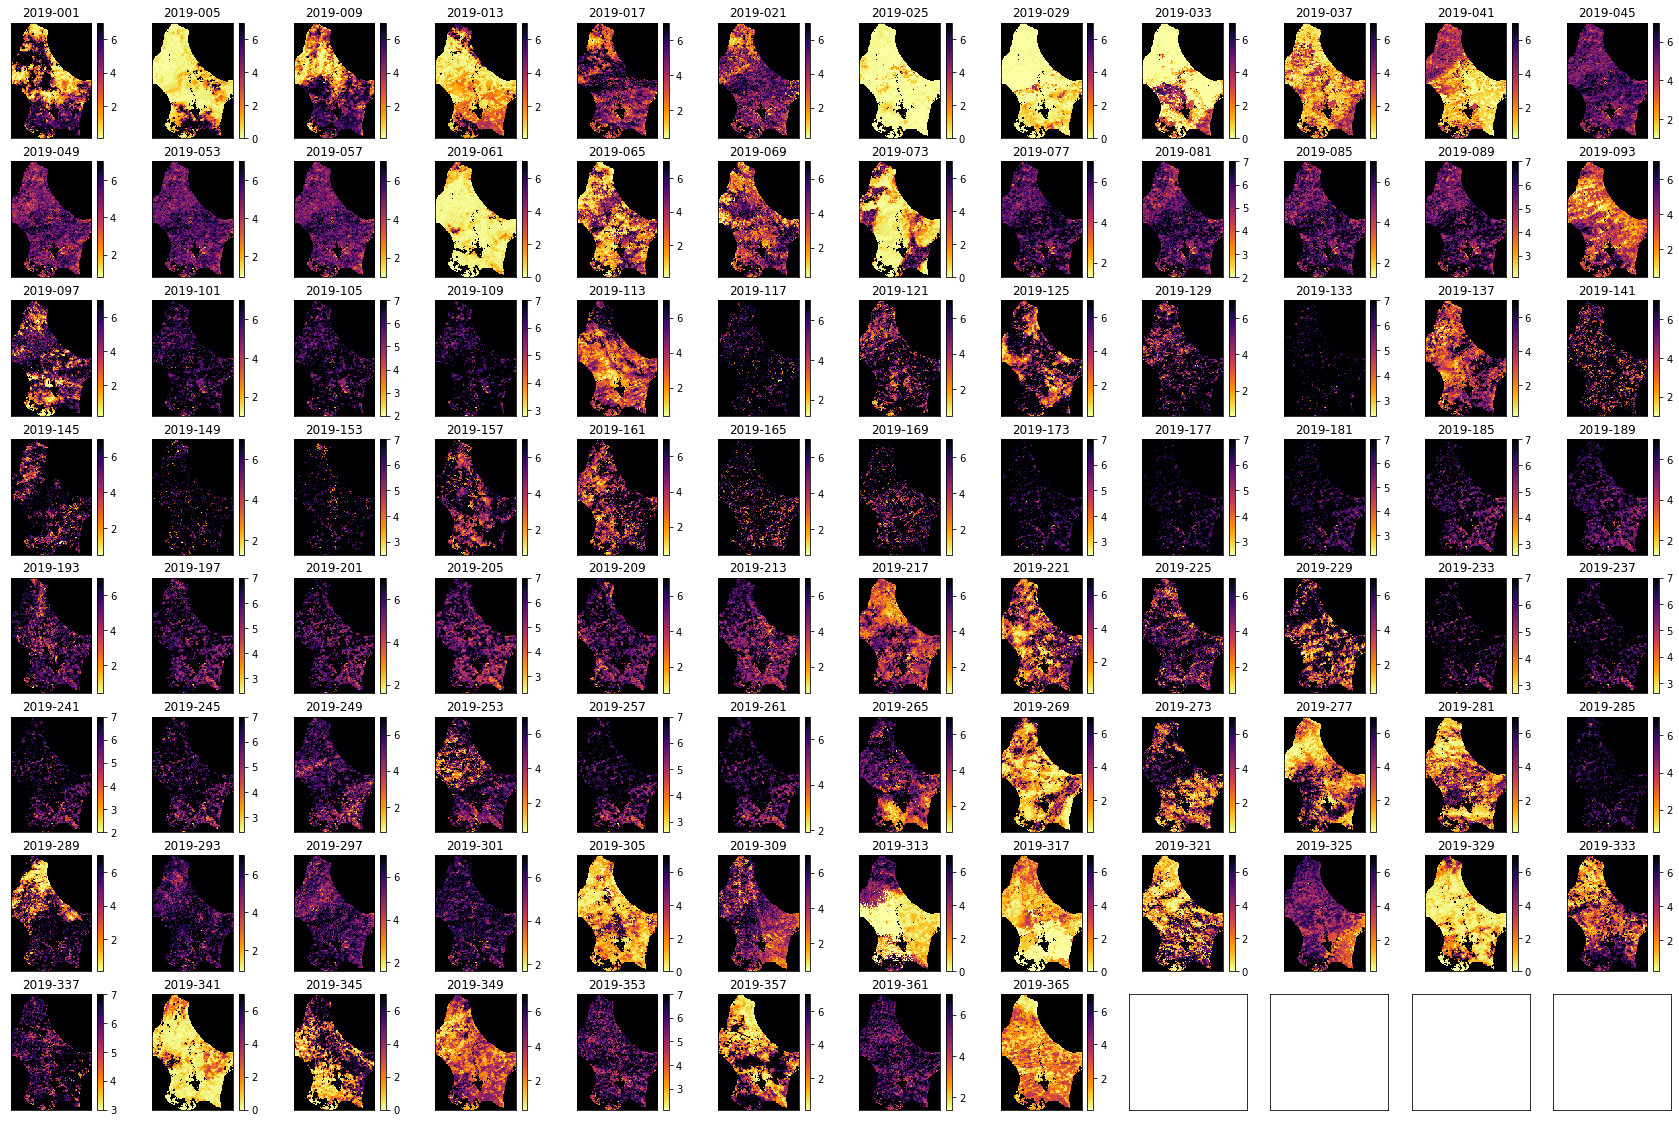

In [22]:
import matplotlib.pyplot as plt
#ANSWER


shape=(8,12)
x_size,y_size=(30,20)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])

for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,cmap=plt.cm.inferno_r,\
                       interpolation='nearest')
    axs[i].set_title(bnames[i])
    fig.colorbar(im, ax=axs[i])

#### Exercise 3

* Write a function `getLai` that takes as argument:
    
        year : integer year
        tile : list of tiles to process
        fips : country fips code (e.g. BE for Belgium)
        
  and returns the annual LAI, standard deviation and day of year

* test your code for Belgium for 2018 for tiles `['h17v03','h18v03','h17v04','h18v04']`
* show the shape of the arrays returned

Hint: You may find it useful to use `modisAnnual`


In [31]:
# ANSWER
import numpy as np
from geog0111.modisUtils import modisAnnual
import gdal

def getLai(year=2019,tile=['h18v03','h18v04'],country='LU',verbose=False):
    '''
    Get LAI and std for year,tile,country
    
    Options:
    You should fill these out!!
    
    '''

    warp_args = {
        'dstNodata'     : 255,
        'format'        : 'MEM',
        'cropToCutline' : True,
        'cutlineWhere'  : f"FIPS='{country}'",
        'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }

    kwargs = {
        'tile'      :    tile,
        'product'   :    'MCD15A3H',
        'sds'       :    ['Lai_500m','LaiStdDev_500m']
    ,
        'doys'      : [i for i in range(1,366,4)],
        'year'      : year,
        'warp_args' : warp_args,
        'verbose'   : False
    }

    # run
    if verbose:
        print(f'gathering modis annual data for {kwargs}')
    odict,bnames = modisAnnual(**kwargs)
    
    # read the data
    if verbose:
        print(f'reading datasets')
    ddict = {}
    for k,v in odict.items():
        if verbose:
            print(f'...{k} -> {v}')
        g = gdal.Open(v)
        if g:
            ddict[k] = g.ReadAsArray()
    
    # scale it
    lai = ddict['Lai_500m'] * 0.1
    std = ddict['LaiStdDev_500m'] * 0.1
    # doy from filenames
    doy = np.array([int(i.split('-')[1]) for i in bnames])
    if verbose:
        print(f'done')
    return lai,std,doy

In [32]:
# Test

tile = ['h17v03','h18v03','h17v04','h18v04']
year = 2018
fips = 'BE'
# test your code for Belgium for 2018 for 
# tiles ['h17v03','h18v03','h17v04','h18v04']
lai,std,doy = getLai(year,tile,fips,verbose=True)
print(f'shape of lai: {lai.shape}')
print(f'shape of std: {std.shape}')
print(f'shape of doy: {doy.shape}')

gathering modis annual data for {'tile': ['h17v03', 'h18v03', 'h17v04', 'h18v04'], 'product': 'MCD15A3H', 'sds': ['Lai_500m', 'LaiStdDev_500m'], 'doys': [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365], 'year': 2018, 'warp_args': {'dstNodata': 255, 'format': 'MEM', 'cropToCutline': True, 'cutlineWhere': "FIPS='BE'", 'cutlineDSName': 'data/TM_WORLD_BORDERS-0.3.shp'}, 'verbose': False}
reading datasets
...Lai_500m -> work/output_filename_Selektor_FIPS_BE_SDS_Lai_500m.vrt
...LaiStdDev_500m -> work/output_filename_Selektor_FIPS_BE_SDS_LaiStdDev_500m.vrt
done
shape of lai: (92, 479, 596)
shape of std: (92, 479, 59